In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("Libraries loaded successfully ✓")

Libraries loaded successfully ✓


## 1. Load Data and Models

In [2]:
# Load operator performance data
df = pd.read_parquet('warehouse/data/operator_performance.parquet')

print(f"Operator performance data loaded: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Operators: {df['operator'].nunique()}")
print(f"\nTier distribution:")
print(df.groupby('operator_tier')['operator'].nunique())

df.head()

Operator performance data loaded: (8203, 9)
Date range: 2024-12-30 00:00:00 to 2025-12-07 00:00:00
Operators: 33

Tier distribution:
operator_tier
Large       5
Large+      3
Medium      6
Medium+     7
Micro       5
Small       5
Top Tier    2
Name: operator, dtype: int64


,operator,date,game_category,GGR,total_stake,total_payout,total_bets,operator_tier,movement_wager_mean
0,SAH,2024-12-30,RRI_fixedOdds,2790238.00,7081448.0,4291210.00,101.0,Medium,4.485354e+06
1,ABA,2024-12-31,RRI_fixedOdds,2229771.94,12286002.0,9898330.06,4707.0,Medium+,4.655199e+07
2,BET,2024-12-31,RRI_fixedOdds,155517.00,122522.0,4305.00,833.0,Small,1.920092e+06
3,ELD,2024-12-31,RRI_casinoGame,0.00,0.0,0.00,0.0,Medium+,6.592497e+07
4,ELD,2024-12-31,RRI_fixedOdds,2993521.00,5526866.0,2533345.00,275.0,Medium+,6.592497e+07


In [3]:
# Load tier-specific models
main_tiers = ['top_tier', 'largeplus', 'large', 'mediumplus', 'medium']
tier_name_mapping = {
    'top_tier': 'Top Tier',
    'largeplus': 'Large+',
    'large': 'Large',
    'mediumplus': 'Medium+',
    'medium': 'Medium'
}

models = {}
for tier_key in main_tiers:
    model_path = f'warehouse/data/models/stake_model_{tier_key}.pkl'
    try:
        models[tier_name_mapping[tier_key]] = joblib.load(model_path)
        print(f"✓ Loaded model for {tier_name_mapping[tier_key]}")
    except Exception as e:
        print(f"✗ Failed to load model for {tier_key}: {str(e)}")

print(f"\nTotal models loaded: {len(models)}")

✓ Loaded model for Top Tier
✓ Loaded model for Large+
✓ Loaded model for Large
✓ Loaded model for Medium+
✓ Loaded model for Medium

Total models loaded: 5


## 2. Calculate Operator Historical Shares

Each operator's historical share of their tier's total stake

In [4]:
# Calculate total stake per operator across all time
operator_totals = df.groupby(['operator', 'operator_tier'])['total_stake'].sum().reset_index()
operator_totals.columns = ['operator', 'operator_tier', 'operator_total_stake']

# Calculate total stake per tier across all time
tier_totals = df.groupby('operator_tier')['total_stake'].sum().reset_index()
tier_totals.columns = ['operator_tier', 'tier_total_stake']

# Merge and calculate shares
operator_shares = operator_totals.merge(tier_totals, on='operator_tier')
operator_shares['historical_share'] = operator_shares['operator_total_stake'] / operator_shares['tier_total_stake']

print("Operator Historical Shares (Top 10 by total stake):")
print("="*80)
display(operator_shares.nlargest(10, 'operator_total_stake')[[
    'operator', 'operator_tier', 'operator_total_stake', 'historical_share'
]])

print(f"\n✓ Calculated historical shares for {len(operator_shares)} operators")

Operator Historical Shares (Top 10 by total stake):


,operator,operator_tier,operator_total_stake,historical_share
18,INT,Top Tier,1.711561e+12,0.963588
14,GAR,Medium+,1.523408e+11,0.915710
29,SPO,Large+,7.371701e+10,0.972197
21,MAS,Top Tier,6.467660e+10,0.036412
11,ENT,Large,8.633849e+09,0.495599
0,ABA,Medium+,8.132817e+09,0.048886
6,BLU,Large,5.755046e+09,0.330351
10,ELD,Medium+,3.722461e+09,0.022375
23,PAR,Large+,2.107886e+09,0.027799
24,QUI,Large,1.983195e+09,0.113839



✓ Calculated historical shares for 33 operators


## 3. Prepare Features for Prediction

In [5]:
def create_ts_features(tier_data):
    """
    Create time-series features matching the training process.
    """
    df_feat = tier_data.copy()
    df_feat = df_feat.sort_values('date').reset_index(drop=True)
    
    # Autoregressive features
    df_feat['stake_lag1'] = df_feat['total_stake'].shift(1)
    df_feat['stake_lag7'] = df_feat['total_stake'].shift(7)
    df_feat['stake_lag14'] = df_feat['total_stake'].shift(14)
    
    # Rolling statistics
    df_feat['stake_ma7'] = df_feat['total_stake'].shift(1).rolling(window=7, min_periods=1).mean()
    df_feat['stake_std7'] = df_feat['total_stake'].shift(1).rolling(window=7, min_periods=1).std()
    
    # Bet volume features
    df_feat['bets_current'] = df_feat['total_bets']
    df_feat['bets_lag1'] = df_feat['total_bets'].shift(1)
    df_feat['bets_ma7'] = df_feat['total_bets'].shift(1).rolling(window=7, min_periods=1).mean()
    
    # Temporal features
    df_feat['day_of_week'] = pd.to_datetime(df_feat['date']).dt.dayofweek
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)
    df_feat['month'] = pd.to_datetime(df_feat['date']).dt.month
    
    return df_feat

# Aggregate to tier-daily and create features
tier_daily = df.groupby(['date', 'operator_tier'], as_index=False).agg({
    'total_stake': 'sum',
    'total_bets': 'sum',
    'total_payout': 'sum',
    'GGR': 'sum'
})

tier_daily = tier_daily.sort_values(['operator_tier', 'date'])

# Create features for each tier
tier_features = {}
for tier in tier_daily['operator_tier'].unique():
    tier_data = tier_daily[tier_daily['operator_tier'] == tier].copy()
    tier_features[tier] = create_ts_features(tier_data)

print("✓ Features prepared for all tiers")

✓ Features prepared for all tiers


## 4. Generate Tier-Expected Predictions

In [6]:
# Generate predictions for each tier
tier_predictions = []

for tier, model_info in models.items():
    print(f"Generating predictions for {tier}...")
    
    # Get tier data with features
    tier_data = tier_features[tier].dropna().copy()
    
    # Get model components
    model = model_info['model']
    scaler = model_info['scaler']
    features = model_info['features']
    
    # Prepare features
    X = tier_data[features]
    X_scaled = scaler.transform(X)
    
    # Make predictions
    tier_data['tier_expected_stake'] = model.predict(X_scaled)
    tier_data['tier_actual_stake'] = tier_data['total_stake']
    
    tier_predictions.append(tier_data[['date', 'operator_tier', 'tier_actual_stake', 'tier_expected_stake']])

# Combine all tier predictions
tier_preds_df = pd.concat(tier_predictions, ignore_index=True)

print(f"\n✓ Generated predictions for {len(tier_preds_df)} tier-days")
print(f"\nSample predictions:")
display(tier_preds_df.head(10))

Generating predictions for Top Tier...
Generating predictions for Large+...
Generating predictions for Large...
Generating predictions for Medium+...
Generating predictions for Medium...

✓ Generated predictions for 1580 tier-days

Sample predictions:


,date,operator_tier,tier_actual_stake,tier_expected_stake
0,2025-01-14,Top Tier,3.029061e+09,2.562557e+09
1,2025-01-15,Top Tier,4.983669e+09,5.492500e+09
2,2025-01-16,Top Tier,4.524799e+09,5.045200e+09
3,2025-01-17,Top Tier,4.491977e+09,3.818146e+09
4,2025-01-18,Top Tier,6.726814e+09,7.273687e+09
5,2025-01-19,Top Tier,6.914550e+09,7.537612e+09
6,2025-01-20,Top Tier,3.858631e+09,3.885721e+09
7,2025-01-21,Top Tier,3.690279e+09,2.790080e+09
8,2025-01-22,Top Tier,5.062901e+09,4.729755e+09
9,2025-01-23,Top Tier,5.990060e+09,5.872099e+09


## 5. Calculate Operator Efficiency Scores

In [7]:
# Merge operator data with tier predictions
operator_daily = df[['date', 'operator', 'operator_tier', 'game_category', 
                     'total_stake', 'total_bets', 'GGR']].copy()

# Aggregate to operator-daily (sum across game categories)
operator_daily = operator_daily.groupby(['date', 'operator', 'operator_tier'], as_index=False).agg({
    'total_stake': 'sum',
    'total_bets': 'sum',
    'GGR': 'sum'
})

# Merge with tier predictions
operator_daily = operator_daily.merge(tier_preds_df, 
                                      on=['date', 'operator_tier'],
                                      how='inner')

# Merge with operator historical shares
operator_daily = operator_daily.merge(operator_shares[['operator', 'historical_share']],
                                      on='operator',
                                      how='left')

# Calculate operator-expected stake
operator_daily['operator_expected_stake'] = operator_daily['tier_expected_stake'] * operator_daily['historical_share']

# Calculate efficiency score
operator_daily['efficiency_score'] = operator_daily['total_stake'] / operator_daily['operator_expected_stake']

# Calculate deviation
operator_daily['stake_deviation'] = operator_daily['total_stake'] - operator_daily['operator_expected_stake']
operator_daily['stake_deviation_pct'] = (operator_daily['stake_deviation'] / operator_daily['operator_expected_stake']) * 100

print(f"✓ Calculated efficiency scores for {len(operator_daily)} operator-days")
print(f"\nSample efficiency scores:")
display(operator_daily[[
    'date', 'operator', 'operator_tier', 'total_stake', 
    'operator_expected_stake', 'efficiency_score'
]].head(10))

✓ Calculated efficiency scores for 4704 operator-days

Sample efficiency scores:


,date,operator,operator_tier,total_stake,operator_expected_stake,efficiency_score
0,2025-01-13,SAH,Medium,4.405298e+06,3.581609e+06,1.229977
1,2025-01-14,ABA,Medium+,2.875925e+07,2.222830e+06,12.938124
2,2025-01-14,ABE,Large,0.000000e+00,3.223590e+05,0.000000
3,2025-01-14,ELD,Medium+,1.697117e+07,1.017408e+06,16.680779
4,2025-01-14,ENT,Large,4.951111e+06,2.653351e+06,1.865985
5,2025-01-14,INT,Top Tier,2.906204e+09,2.469249e+09,1.176959
6,2025-01-14,MAS,Top Tier,1.228565e+08,9.330814e+07,1.316675
7,2025-01-14,RUB,Medium+,0.000000e+00,0.000000e+00,NaN
8,2025-01-14,SAH,Medium,5.750073e+06,3.623681e+06,1.586804
9,2025-01-15,ABA,Medium+,2.515716e+07,2.079402e+06,12.098269


## 6. Aggregate Efficiency Metrics per Operator

In [8]:
# Calculate aggregate metrics per operator
operator_efficiency = operator_daily.groupby(['operator', 'operator_tier']).agg({
    'efficiency_score': ['mean', 'median', 'std', 'min', 'max'],
    'total_stake': 'sum',
    'operator_expected_stake': 'sum',
    'stake_deviation': 'sum',
    'GGR': 'sum',
    'date': 'count'  # Number of days
}).reset_index()

# Flatten column names
operator_efficiency.columns = ['operator', 'operator_tier', 
                               'efficiency_mean', 'efficiency_median', 'efficiency_std', 
                               'efficiency_min', 'efficiency_max',
                               'total_stake_sum', 'expected_stake_sum', 'stake_deviation_sum',
                               'total_ggr', 'n_days']

# Calculate overall efficiency (cumulative)
operator_efficiency['overall_efficiency'] = operator_efficiency['total_stake_sum'] / operator_efficiency['expected_stake_sum']

# Calculate deviation percentage
operator_efficiency['deviation_pct'] = (operator_efficiency['stake_deviation_sum'] / operator_efficiency['expected_stake_sum']) * 100

# Sort by overall efficiency
operator_efficiency = operator_efficiency.sort_values('overall_efficiency', ascending=False)

print("="*100)
print("OPERATOR EFFICIENCY RANKINGS")
print("="*100)
print("\nTop 10 Most Efficient Operators (Overall Efficiency Score):")
print("-" * 100)
display(operator_efficiency.head(10)[[
    'operator', 'operator_tier', 'overall_efficiency', 'efficiency_mean', 
    'deviation_pct', 'total_stake_sum', 'total_ggr'
]].round(3))

print("\n" + "="*100)
print("Bottom 10 Least Efficient Operators:")
print("-" * 100)
display(operator_efficiency.tail(10)[[
    'operator', 'operator_tier', 'overall_efficiency', 'efficiency_mean',
    'deviation_pct', 'total_stake_sum', 'total_ggr'
]].round(3))

OPERATOR EFFICIENCY RANKINGS

Top 10 Most Efficient Operators (Overall Efficiency Score):
----------------------------------------------------------------------------------------------------


,operator,operator_tier,overall_efficiency,efficiency_mean,deviation_pct,total_stake_sum,total_ggr
3,AKE,Medium+,174.277,202.980,17327.720,1.689648e+08,6.048979e+07
4,ARC,Large+,57.409,61.181,5640.903,2.945849e+05,1.545958e+05
21,SYN,Medium,8.494,6.162,749.365,2.492911e+07,-3.891610e+08
22,WOR,Medium+,3.094,18.627,209.409,1.919016e+09,3.437698e+08
9,GAM,Medium+,2.107,15.536,110.685,7.954888e+07,8.098075e+06
6,DAY,Medium,1.941,2.411,94.128,1.767734e+08,2.745112e+07
2,ADV,Medium,1.875,1.673,87.543,3.065951e+07,6.258857e+06
15,PAR,Large+,1.631,1.694,63.060,2.107886e+09,-5.025678e+07
16,QUI,Large,1.095,1.773,9.511,1.983195e+09,7.041188e+08
5,BLU,Large,1.071,1.488,7.063,5.755046e+09,2.057523e+09



Bottom 10 Least Efficient Operators:
----------------------------------------------------------------------------------------------------


,operator,operator_tier,overall_efficiency,efficiency_mean,deviation_pct,total_stake_sum,total_ggr
1,ABE,Large,1.012,2.757,1.172,9.994510e+08,2.647259e+08
8,ENT,Large,1.009,0.784,0.886,8.618003e+09,3.903086e+08
11,INT,Top Tier,1.000,0.996,-0.026,1.658560e+12,3.844811e+11
20,SPO,Large+,0.998,0.982,-0.201,7.073554e+10,8.178062e+09
0,ABA,Medium+,0.968,8.082,-3.244,7.787869e+09,1.943704e+09
7,ELD,Medium+,0.961,7.910,-3.906,3.566294e+09,4.404778e+08
12,KEF,Large,NaN,NaN,NaN,0.000000e+00,0.000000e+00
14,NAT,Medium,NaN,NaN,NaN,0.000000e+00,0.000000e+00
17,REY,Medium,NaN,NaN,NaN,0.000000e+00,0.000000e+00
18,RUB,Medium+,NaN,NaN,NaN,0.000000e+00,0.000000e+00


## 7. Visualize Efficiency by Tier

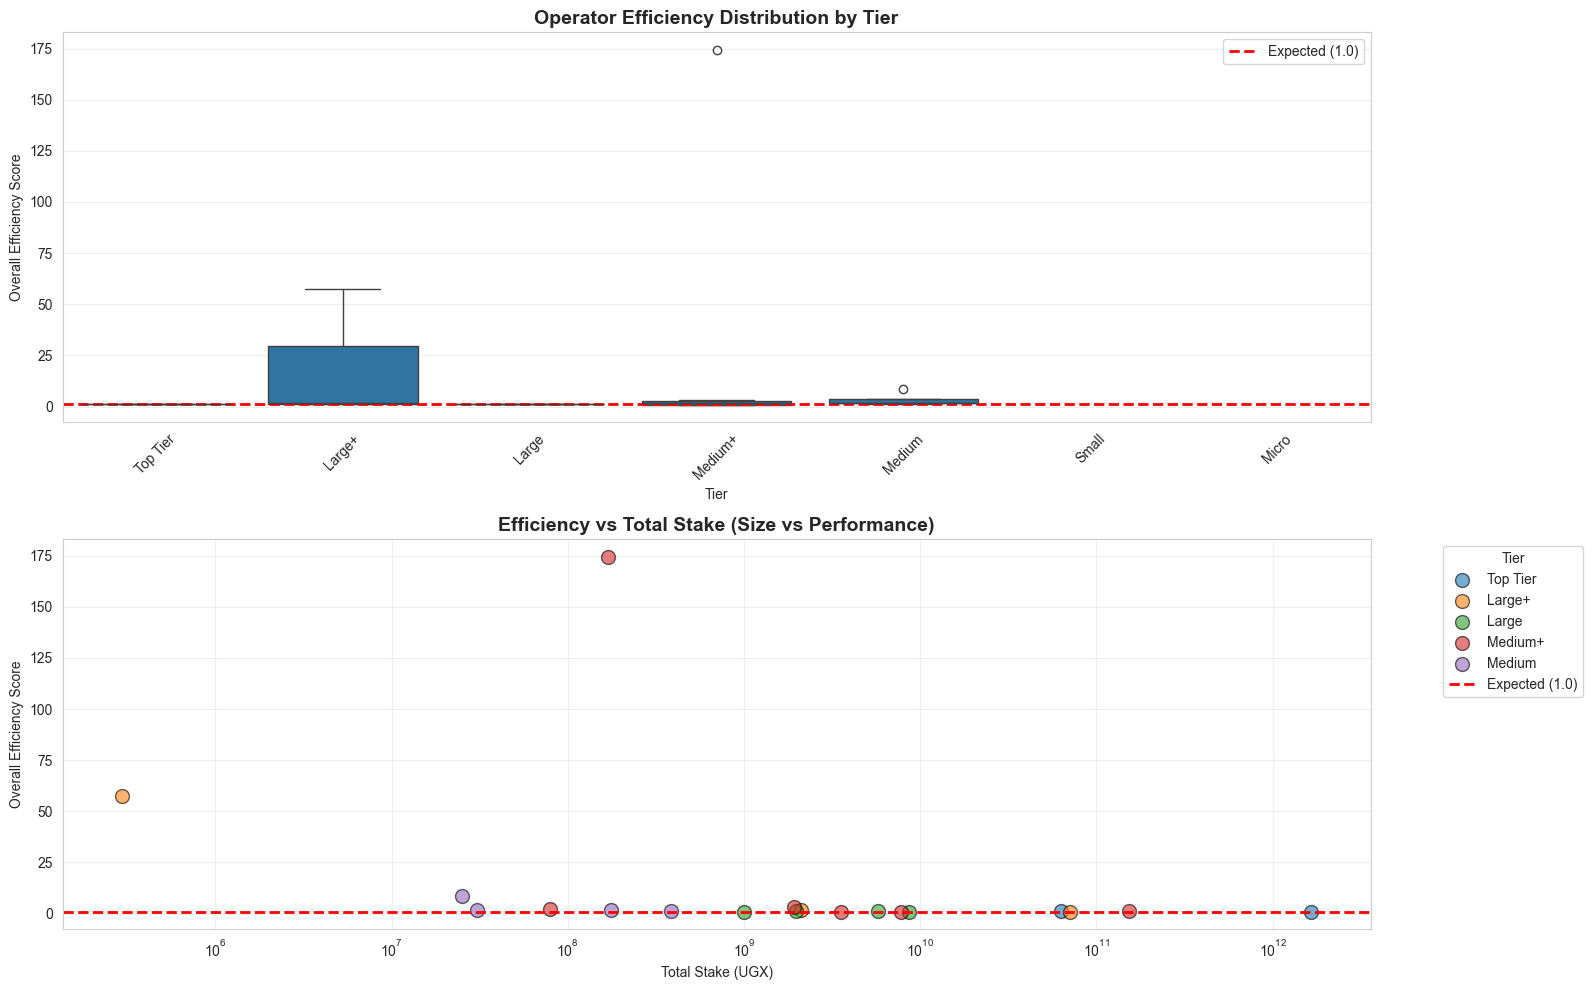


✓ Efficiency visualization complete


In [9]:
# Plot efficiency distribution by tier
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Box plot of efficiency scores by tier
tier_order = ['Top Tier', 'Large+', 'Large', 'Medium+', 'Medium', 'Small', 'Micro']
operator_efficiency_sorted = operator_efficiency.copy()
operator_efficiency_sorted['operator_tier'] = pd.Categorical(
    operator_efficiency_sorted['operator_tier'], 
    categories=tier_order, 
    ordered=True
)
operator_efficiency_sorted = operator_efficiency_sorted.sort_values('operator_tier')

sns.boxplot(data=operator_efficiency_sorted, x='operator_tier', y='overall_efficiency', ax=axes[0])
axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Expected (1.0)')
axes[0].set_title('Operator Efficiency Distribution by Tier', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tier')
axes[0].set_ylabel('Overall Efficiency Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot: Efficiency vs Total Stake
for tier in operator_efficiency_sorted['operator_tier'].unique():
    tier_data = operator_efficiency_sorted[operator_efficiency_sorted['operator_tier'] == tier]
    axes[1].scatter(tier_data['total_stake_sum'], tier_data['overall_efficiency'], 
                   label=tier, s=100, alpha=0.6, edgecolors='black')

axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Expected (1.0)')
axes[1].set_title('Efficiency vs Total Stake (Size vs Performance)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Stake (UGX)')
axes[1].set_ylabel('Overall Efficiency Score')
axes[1].set_xscale('log')
axes[1].legend(title='Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Efficiency visualization complete")

## 8. Identify Outlier Operators (High/Low Efficiency)

In [10]:
# Calculate z-scores within each tier
operator_efficiency['efficiency_zscore'] = operator_efficiency.groupby('operator_tier')['overall_efficiency'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Identify outliers (|z-score| > 2)
high_performers = operator_efficiency[operator_efficiency['efficiency_zscore'] > 2].copy()
low_performers = operator_efficiency[operator_efficiency['efficiency_zscore'] < -2].copy()

print("="*100)
print("OUTLIER OPERATORS (z-score > 2 or < -2 within tier)")
print("="*100)

if len(high_performers) > 0:
    print(f"\n🔥 HIGH PERFORMERS ({len(high_performers)} operators):")
    print("-" * 100)
    display(high_performers[[
        'operator', 'operator_tier', 'overall_efficiency', 'efficiency_zscore',
        'deviation_pct', 'total_stake_sum', 'total_ggr'
    ]].round(3))
else:
    print("\n🔥 HIGH PERFORMERS: None (no operators with z-score > 2)")

if len(low_performers) > 0:
    print(f"\n⚠️  LOW PERFORMERS ({len(low_performers)} operators):")
    print("-" * 100)
    display(low_performers[[
        'operator', 'operator_tier', 'overall_efficiency', 'efficiency_zscore',
        'deviation_pct', 'total_stake_sum', 'total_ggr'
    ]].round(3))
else:
    print("\n⚠️  LOW PERFORMERS: None (no operators with z-score < -2)")

print("\n" + "="*100)

OUTLIER OPERATORS (z-score > 2 or < -2 within tier)

🔥 HIGH PERFORMERS (1 operators):
----------------------------------------------------------------------------------------------------


,operator,operator_tier,overall_efficiency,efficiency_zscore,deviation_pct,total_stake_sum,total_ggr
3,AKE,Medium+,174.277,2.041,17327.72,1.689648e+08,60489789.41



⚠️  LOW PERFORMERS: None (no operators with z-score < -2)



## 9. Time Series of Efficiency (Recent Trend)

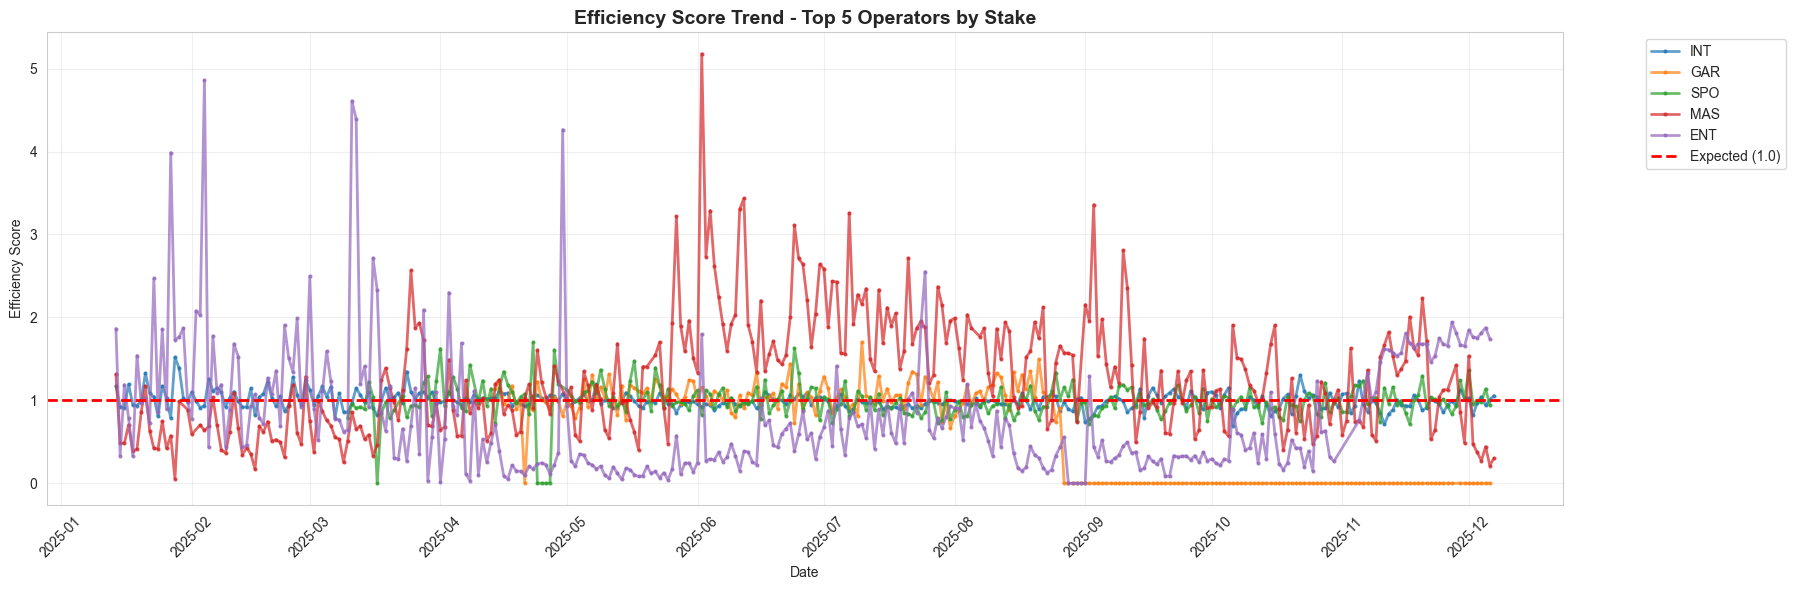


✓ Efficiency trends visualized for top 5 operators


In [11]:
# Select top 5 operators by total stake for trend analysis
top_operators = operator_efficiency.nlargest(5, 'total_stake_sum')['operator'].tolist()

# Filter operator_daily for these operators
top_ops_daily = operator_daily[operator_daily['operator'].isin(top_operators)].copy()
top_ops_daily = top_ops_daily.sort_values('date')

# Plot efficiency trends
fig, ax = plt.subplots(figsize=(18, 6))

for op in top_operators:
    op_data = top_ops_daily[top_ops_daily['operator'] == op]
    ax.plot(op_data['date'], op_data['efficiency_score'], 
           label=op, linewidth=2, alpha=0.7, marker='o', markersize=2)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Expected (1.0)')
ax.set_title('Efficiency Score Trend - Top 5 Operators by Stake', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Efficiency Score')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Efficiency trends visualized for top 5 operators")

## 10. Save Results

In [12]:
# Save operator efficiency summary
operator_efficiency.to_parquet('warehouse/data/operator_efficiency.parquet', index=False)
print("✓ Saved: warehouse/data/operator_efficiency.parquet")

# Save daily efficiency data
operator_daily.to_parquet('warehouse/data/operator_efficiency_daily.parquet', index=False)
print("✓ Saved: warehouse/data/operator_efficiency_daily.parquet")

# Save tier predictions
tier_preds_df.to_parquet('warehouse/data/tier_predictions.parquet', index=False)
print("✓ Saved: warehouse/data/tier_predictions.parquet")

print("\n" + "="*100)
print("ALL RESULTS SAVED")
print("="*100)

✓ Saved: warehouse/data/operator_efficiency.parquet
✓ Saved: warehouse/data/operator_efficiency_daily.parquet
✓ Saved: warehouse/data/tier_predictions.parquet

ALL RESULTS SAVED


## 11. Summary Report

In [13]:
print("\n" + "="*100)
print("OPERATOR EFFICIENCY ANALYSIS - SUMMARY")
print("="*100)

print("\n📊 KEY STATISTICS")
print("-" * 100)
print(f"Total operators analyzed: {len(operator_efficiency)}")
print(f"Total operator-days: {len(operator_daily):,}")
print(f"Date range: {operator_daily['date'].min()} to {operator_daily['date'].max()}")

print("\n📈 EFFICIENCY DISTRIBUTION")
print("-" * 100)
print(f"Mean efficiency score: {operator_efficiency['overall_efficiency'].mean():.3f}")
print(f"Median efficiency score: {operator_efficiency['overall_efficiency'].median():.3f}")
print(f"Std deviation: {operator_efficiency['overall_efficiency'].std():.3f}")
print(f"Min efficiency: {operator_efficiency['overall_efficiency'].min():.3f} ({operator_efficiency.loc[operator_efficiency['overall_efficiency'].idxmin(), 'operator']})")
print(f"Max efficiency: {operator_efficiency['overall_efficiency'].max():.3f} ({operator_efficiency.loc[operator_efficiency['overall_efficiency'].idxmax(), 'operator']})")

print("\n🎯 EFFICIENCY CATEGORIES")
print("-" * 100)
highly_efficient = operator_efficiency[operator_efficiency['overall_efficiency'] > 1.2]
efficient = operator_efficiency[(operator_efficiency['overall_efficiency'] > 1.0) & (operator_efficiency['overall_efficiency'] <= 1.2)]
average = operator_efficiency[(operator_efficiency['overall_efficiency'] >= 0.8) & (operator_efficiency['overall_efficiency'] <= 1.0)]
inefficient = operator_efficiency[operator_efficiency['overall_efficiency'] < 0.8]

print(f"Highly Efficient (>1.2): {len(highly_efficient)} operators ({len(highly_efficient)/len(operator_efficiency)*100:.1f}%)")
print(f"Efficient (1.0-1.2): {len(efficient)} operators ({len(efficient)/len(operator_efficiency)*100:.1f}%)")
print(f"Average (0.8-1.0): {len(average)} operators ({len(average)/len(operator_efficiency)*100:.1f}%)")
print(f"Inefficient (<0.8): {len(inefficient)} operators ({len(inefficient)/len(operator_efficiency)*100:.1f}%)")

print("\n🏆 TOP 5 MOST EFFICIENT OPERATORS")
print("-" * 100)
for idx, row in operator_efficiency.head(5).iterrows():
    print(f"{row['operator']:8s} ({row['operator_tier']:10s}): {row['overall_efficiency']:.3f} "
          f"({row['deviation_pct']:+.1f}% vs expected, GGR: UGX {row['total_ggr']:,.0f})")

print("\n⚠️  BOTTOM 5 LEAST EFFICIENT OPERATORS")
print("-" * 100)
for idx, row in operator_efficiency.tail(5).iterrows():
    print(f"{row['operator']:8s} ({row['operator_tier']:10s}): {row['overall_efficiency']:.3f} "
          f"({row['deviation_pct']:+.1f}% vs expected, GGR: UGX {row['total_ggr']:,.0f})")

print("\n" + "="*100)
print("💡 REGULATORY INSIGHTS")
print("="*100)

print("\n1. EFFICIENCY vs TIER DESIGN VALIDATED:")
print("   • Tiers based on operational scale (movement_wager_amt)")
print("   • Efficiency measures performance within scale tier")
print("   • Successfully separates 'how big' from 'how well performing'")

print("\n2. FAIR PEER COMPARISON ENABLED:")
print("   • Operators compared to tier-expected performance")
print("   • Small efficient operators identified (punching above weight)")
print("   • Large inefficient operators identified (underperforming)")

print("\n3. ACTIONABLE FOR REGULATION:")
print("   • Efficiency score > 1.2: Investigate for best practices")
print("   • Efficiency score < 0.8: Investigate for operational issues")
print("   • Sudden efficiency drops: Potential fraud/technical issues")
print("   • Consistent high efficiency: Reward/certify operators")

print("\n" + "="*100)
print("✅ OPERATOR EFFICIENCY ANALYSIS COMPLETE")
print("="*100)


OPERATOR EFFICIENCY ANALYSIS - SUMMARY

📊 KEY STATISTICS
----------------------------------------------------------------------------------------------------
Total operators analyzed: 23
Total operator-days: 4,704
Date range: 2025-01-13 00:00:00 to 2025-12-07 00:00:00

📈 EFFICIENCY DISTRIBUTION
----------------------------------------------------------------------------------------------------
Mean efficiency score: 13.793
Median efficiency score: 1.071
Std deviation: 40.934
Min efficiency: 0.961 (ELD)
Max efficiency: 174.277 (AKE)

🎯 EFFICIENCY CATEGORIES
----------------------------------------------------------------------------------------------------
Highly Efficient (>1.2): 8 operators (34.8%)
Efficient (1.0-1.2): 7 operators (30.4%)
Average (0.8-1.0): 4 operators (17.4%)
Inefficient (<0.8): 0 operators (0.0%)

🏆 TOP 5 MOST EFFICIENT OPERATORS
----------------------------------------------------------------------------------------------------
AKE      (Medium+   ): 174.277 (+173